<a href="https://colab.research.google.com/github/AeneasWeiChiHsu/AeneasWeiChiHsu/blob/main/Prioritized_Multi_Step_Double_Dual_Head_DQN_CarRacing_RL_Project_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

⚠️ **不要熬夜寫code。**

# Introduction: Double Duel DQN on Car Racing v3

這個版本是大雜燴。

⬆️ DQN

⬆️ Dual Head

⬆️ Double Netword （Advanced + Target）

⬆️ Multiple Step Memory（取代 Single Step——SARSA——演算法）

⬆️ Epsilon modification（adaptive epsilon strategy）

⬆️ Reward shaping（誘導）

⬆️ Residual Connection（實驗）

⬆️ Attention Mechanism（實驗）

> 因為我不會開車，所以我決定訓練一個Agent來開車。

本集特別感謝：IBM 在 Coursera 上的線上課程 [Deep Learning with Keras and TensorFlow](https://www.coursera.org/learn/building-deep-learning-models-with-tensorflow/home)

詳細內容請參考：[Building a Deep Q-Network with Keras](https://www.coursera.org/learn/building-deep-learning-models-with-tensorflow/ungradedLti/AlszB/lab-building-a-deep-q-network-with-keras)

本集特別感謝：University of Alberta 在 Coursera 上的線上課程 [Fundamentals of Reinforcement Learning](https://www.coursera.org/learn/fundamentals-of-reinforcement-learning/home)


# Goal: Deep Q-Network with Keras

故事是這樣的，我之前上過一門課，叫做《控制理論》，但是內容都是在講 Reinforcement Learning。
不過那個時候我什麼都不懂，只是想要做完期末專題：CarRacing。
所以我在Github上面看到有人 share 了一段 DualDQN 的code，我覺得很棒，我就拿來改。
最後那個不是我的 Agent 幫我完成了我的 Final Project。
不過那段 Code 是用 pytorch 寫的。但是基於某些理由我不喜歡 pytorch。
現在我要做這個 Project。

## Box2D

請參考 OpenAI gymnasium 的說明來安裝相對應的東西
https://gymnasium.farama.org/environments/box2d/

In [1]:
# Instal Gym
!pip install gymnasium
! pip install swig
! pip install gymnasium[box2d]
# Install OpenCV
!pip install opencv-python

# ==== Note ====
# If you are run it in local jupyter lab, uncomment this line
#!pip install box2d pygame

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379368 sha256=af3f8dfcd5b339186d6b3462329623be86c67a57703a3e31045545581e3aa43d
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from collections import deque
from tensorflow.keras.models import Model

# ==== Layers ====
from tensorflow.keras.layers import Input, InputLayer, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization, ReLU, MaxPooling2D, UpSampling2D, Concatenate, Activation, Lambda, Add, LayerNormalization, LeakyReLU, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, ZeroPadding2D, Cropping2D, ZeroPadding1D, Cropping1D, Layer

from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization

# ==== Optimizer ====
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl

# ==== Callbacks ====
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
from tqdm import tqdm
from tqdm import trange
from collections import Counter
# ==== Video ====
import imageio
import os
import cv2 # Import cv2 here

# Environment

https://gymnasium.farama.org/environments/box2d/car_racing/

Actions = [do nothing, left, right, gas, brake]

Observation = **A top-down 96x96 RGB image of the car and race track.**


In [4]:
env = gym.make("CarRacing-v3",
               render_mode= None,
               lap_complete_percent=0.95,
               domain_randomize=False,
               continuous=False)

env.close()

# Model


⬇️ 這邊使用 Duel DQN 的模型做法。所以會有兩個 head（Advanced、Value）。

另外，我們採用了 Stack Frame (RGB)，因此 CNN 的 Input 需要改成 96x96x12.

如果要用 Gray 就是 96x96x4。（3個RGB+1個Gray的Stacked Frame）

如果什麼都不做就是 96x96x3。（3個RGB）

20250519

➡️ 這邊我做了 Residual Connect 的測試。
我保留了原先本DuelDQN架構，然後在convolution裡面加入Residual connection，試圖保留空間特徵。

---
⬇️ 我的感想

📦 每次設計模型都像是在開獎。我們只能夠祈禱這次出來的不會是垃圾。

📈 每一隻模型都像是股票。

In [30]:
import tensorflow as tf
from keras.saving import register_keras_serializable

@register_keras_serializable()

def dueling_q_output(x):
    v, a = x
    return v + (a - tf.reduce_mean(a, axis=1, keepdims=True))

# ==== Build Model ====
# If you use stack frame, the input is (96, 96, 12)
# If you don't use stack frame, the input is (96, 96, 3)
def build_model (input_shape = (96, 96, 12), action_size = 5):
  inputs = Input(shape = input_shape)

  # Normalize pixel [0,255] → [0,1]
  x = tf.keras.layers.Rescaling(1./255)(inputs)

  # ==== Convolution Layers ====
  # Don't use BatchNormalization()
  # 這邊可以把 16 → 32 變成 32 → 64
  # Input 96 → (96 - 8)/4 + 1 = 23
  x = Conv2D(16, (8, 8), strides=4, activation = None)(x)
  #x = MaxPooling2D(pool_size=(2, 2))(x)
  # ReLU or LeakyReLU
  x = LeakyReLU()(x)

  # ==== Residual Start ====
  # Experiment: I use the residual trick here, if it gets worse, comment this
  #residual = x
  #x = Conv2D(16, (3, 3), strides=1, activation = None, padding = 'same')(x)
  #x = ReLU()(x)
  #x = Conv2D(16, (3, 3), strides=1, activation = None, padding = 'same')(x)
  #residual = Conv2D(16, (1, 1), strides=1, activation = None, padding = 'same')(residual)

  #x = Add()([x, residual])
  #x = ReLU()(x)

  # ==== Residual End ====

  # Input 23 → (23 - 4)/2 + 1 = 10
  x = Conv2D(32, (4, 4), strides=2, activation = None)(x)
  #x = MaxPooling2D(pool_size=(2, 2))(x)
  x = ReLU()(x)

  # Input 10 → (10 - 3)/1 + 1 = 8
  x = Conv2D(64, (3, 3), strides=1, activation = None)(x)
  x = ReLU()(x)

  # Input 8 → (8 - 3)/1 + 1 = 6
  x = Conv2D(128, (3, 3), strides=1, activation = None)(x)
  x = ReLU()(x)

  # ==== Self Attention ====
  #x = Reshape((-1, x.shape[-1]))(x)  # [B, H*W, C]
  # Attention Layer 1
  #attn1 = MultiHeadAttention(num_heads=2, key_dim=32)(x, x)
  #x = Add()([x, attn1])
  #x = LayerNormalization()(x)

  # Attention Layer 2
  #attn2 = MultiHeadAttention(num_heads=2, key_dim=32)(x, x)
  #x = Add()([x, attn2])
  #x = LayerNormalization()(x)
  # ==== Self Attention End ====

  # ==== Flaten ====
  x = Flatten()(x)

  # ==== Deep Layers ====
  x = Dense(512, activation='relu')(x)
  #x = Dropout(0.2)(x)

  x = Dense(256, activation='relu')(x)
  #x = Dropout(0.2)(x)

  #x = Dense(128, activation='relu')(x)

  #x = Dense(64, activation='relu')(x)

  # ==== Dueling DQN =====
  # Two head mechanism
  # Advantage Stream
  a = Dense(256, activation='relu', name = 'Adv_1')(x)
  a = Dense(128, activation='relu', name = 'Adv_2')(x)
  a = Dense(action_size)(a)


  # Value Stream
  v = Dense(256, activation='relu', name = 'Value_1')(x)
  v = Dense(128, activation='relu', name = 'Value_2')(x)
  v = Dense(1)(v)

  # ==== Output ====
  # Q-values for each discrete action
  # Output: q_values = [[12.3, 11.8, 9.5, 14.2, 13.0]]
  # The q_values of each action
  # i.e., Q(s, a = 0) = 12.3
  # i.e., Q(s, a =1) = 11.8
  #outputs = Dense(action_size, activation='linear', name = 'Q-values')(x)

  # ==== Dueling DQN Output ====
  # Q(s, a) = V(s) + (A(s, a) - mean(A(s, a')))
  # V(s) -> (batch_size, 1)
  # A(s, a) -> (batch_size, action_size)

  # ==== Output ====
  # Note: Remember add "output_shape = (None, action_size)"
  outputs = Lambda(dueling_q_output, output_shape=(action_size,))([v, a])
  # ==== Model Build ====
  model = Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer=Adam(learning_rate=0.00025), loss='huber')

  return model

# ==== Car Racing parameters ====
state_size = 96*96*12
action_size = 5

# ====
model = build_model(input_shape = (96, 96, 12), action_size = 5)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 96, 96,    │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 96, 96,    │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 23, 23,    │     12,304 │ rescaling_2[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 23, 23,    │          0 │ conv2d_9[0][0]    │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 10, 10,    │      8,224 │ leaky_re_lu_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_6 (ReLU)      │ (None, 10, 10,    │          0 │ conv2d_10[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 8, 8, 64)  │     18,496 │ re_lu_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_7 (ReLU)      │ (None, 8, 8, 64)  │          0 │ conv2d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 6, 6, 128) │     73,856 │ re_lu_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_8 (ReLU)      │ (None, 6, 6, 128) │          0 │ conv2d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 4608)      │          0 │ re_lu_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 512)       │  2,359,808 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 256)       │    131,328 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Value_2 (Dense)     │ (None, 128)       │     32,896 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Adv_2 (Dense)       │ (None, 128)       │     32,896 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │        129 │ Value_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 5)         │        645 │ Adv_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 5)         │          0 │ dense_13[0][0],   │
│                     │                   │            │ dense_12[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,670,582 (10.19 MB)

 Trainable params: 2,670,582 (10.19 MB)

 Non-trainable params: 0 (0.00 B)

# Implement the replay buffer (Memory)

⬇️ Memory 怎麼處理也是個學問。

這是single step 的memory 寫法，很直接。但是我們這邊要實作 multiple step



```
memory = deque(maxlen=10000)
def remember(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))
```




⬇️ SumTree

In [35]:
class SumTree:
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)  # binary tree
        self.data = np.zeros(capacity, dtype=object)  # actual data
        self.write = 0
        self.n_entries = 0

    def _propagate(self, idx, change):
        parent = (idx - 1) // 2
        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        return self.tree[0]

    def add(self, priority, data):
        idx = self.write + self.capacity - 1
        self.data[self.write] = data
        self.update(idx, priority)
        #print(f"Added to tree_idx={idx}, priority={priority}, data={data}")
        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

        self.n_entries = min(self.n_entries + 1, self.capacity)

    def update(self, idx, priority):
        change = priority - self.tree[idx]
        self.tree[idx] = priority
        self._propagate(idx, change)

    def get(self, s):
        idx = self._retrieve(0, s)
        data_idx = idx - self.capacity + 1
        return (idx, self.tree[idx], self.data[data_idx])

In [16]:
# ==== Sum Tree Test Cell ====
# 假設 SumTree class 已經正確實作並可被引用
tree = SumTree(capacity=5)

# 插入 5 筆資料，每筆有不同 priority
for i in range(5):
    priority = (i + 1) * 10  # 10, 20, ..., 50
    data = f"data_{i}"
    tree.add(priority, data)
    print(f"✅ Added {data} with priority {priority}")

print("\n🌳 Tree total priority:", tree.total())  # 應該是 10 + 20 + 30 + 40 + 50 = 150

# 用 get() 模擬從 0 ~ total() 中隨機取樣
print("\n🎯 Sampling test:")
for s in [5, 15, 35, 75, 125]:
    idx, p, data = tree.get(s)
    print(f"s={s:>3} → index={idx}, priority={p}, data={data}")

Added to tree_idx=4, priority=10, data=data_0
✅ Added data_0 with priority 10
Added to tree_idx=5, priority=20, data=data_1
✅ Added data_1 with priority 20
Added to tree_idx=6, priority=30, data=data_2
✅ Added data_2 with priority 30
Added to tree_idx=7, priority=40, data=data_3
✅ Added data_3 with priority 40
Added to tree_idx=8, priority=50, data=data_4
✅ Added data_4 with priority 50

🌳 Tree total priority: 150.0

🎯 Sampling test:
s=  5 → index=7, priority=40.0, data=data_3
s= 15 → index=7, priority=40.0, data=data_3
s= 35 → index=7, priority=40.0, data=data_3
s= 75 → index=8, priority=50.0, data=data_4
s=125 → index=6, priority=30.0, data=data_2


In [19]:
# ==== Test Sum Tree ====
tree = SumTree(capacity=5)

# Add 5 items
for i in range(5):
    tree.add(priority=(i + 1) * 10, data=f"data_{i}")  # Priorities: 10, 20, ..., 50

print(f"🌳 Initial total: {tree.total()}")  # Expect 150

# === Test update ===
# Let's update index 7 (data_3) to a new priority = 100
tree_idx = 7
tree.update(tree_idx, 100)

# Check tree total
print(f"🌳 After update total: {tree.total()}")  # Expect: 150 - 40 + 100 = 210

# === Sampling ===
print("\n🎯 Sampling after update:")
for s in [5, 15, 45, 105, 175]:
    idx, priority, data = tree.get(s)
    print(f"s={s:<3} → index={idx}, priority={priority}, data={data}")

Added to tree_idx=4, priority=10, data=data_0
Added to tree_idx=5, priority=20, data=data_1
Added to tree_idx=6, priority=30, data=data_2
Added to tree_idx=7, priority=40, data=data_3
Added to tree_idx=8, priority=50, data=data_4
🌳 Initial total: 150.0
🌳 After update total: 210.0

🎯 Sampling after update:
s=5   → index=7, priority=100.0, data=data_3
s=15  → index=7, priority=100.0, data=data_3
s=45  → index=7, priority=100.0, data=data_3
s=105 → index=8, priority=50.0, data=data_4
s=175 → index=5, priority=20.0, data=data_1


⬇️ Buffer

In [24]:
class PrioritizedMultiStepReplayBuffer:
    def __init__(self, capacity=100000, n_step=5, gamma=0.99):
        self.tree = SumTree(capacity)  # ← 重點：換掉 deque
        self.capacity = capacity
        self.n_step = n_step
        self.gamma = gamma
        self.n_step_buffer = deque(maxlen=n_step)
        self.max_priority = 1.0  # 初始化用，避免剛開始 priority 全是 0

    def store(self, state, action, reward, next_state, done):
    # 先加入 n-step 暫存
        self.n_step_buffer.append((state, action, reward, next_state, done))

        # 如果達到 n 步，處理真正的 transition
        if len(self.n_step_buffer) == self.n_step:
            s, a, _, _, _ = self.n_step_buffer[0]
            R, s_n, done_n = self._compute_n_step_return()
            transition = (s, a, R, s_n, done_n)
            self.tree.add(self.max_priority, transition)
            self.n_step_buffer.popleft()

        # 如果 episode 結束，把還沒塞完 n_step 的也清掉
        if done:
            while len(self.n_step_buffer) > 0:
                s, a, _, _, _ = self.n_step_buffer[0]
                R, s_n, done_n = self._compute_n_step_return()
                transition = (s, a, R, s_n, done_n)
                self.tree.add(self.max_priority, transition)
                self.n_step_buffer.popleft()

    def _compute_n_step_return(self):
        R = 0
        for idx, (_, _, r, _, d) in enumerate(self.n_step_buffer):
            R += (self.gamma ** idx) * r
            if d:
                break
        s_n = self.n_step_buffer[idx][3]
        done_n = self.n_step_buffer[idx][4]
        return R, s_n, done_n

    def sample(self, batch_size, beta=0.4):
        indices = []
        priorities = []
        transitions = []

        # 總 priority
        total = self.tree.total()
        if total == 0:
          raise ValueError("Cannot sample from an empty SumTree with total priority 0.")

        # 每段分區（segment）大小
        segment = total / batch_size

        for i in range(batch_size):
            a = segment * i
            b = segment * (i + 1)
            s = np.random.uniform(a, b)  # Uniform sampling in [a, b]
            idx, p, data = self.tree.get(s)
            priorities.append(p)
            transitions.append(data)
            indices.append(idx)

        # normalize IS weights
        probs = np.array(priorities) / total
        weights = (self.tree.n_entries * probs) ** (-beta)
        weights /= weights.max()  # normalize

        # Unpack batch
        states, actions, rewards, next_states, dones = zip(*transitions)

        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(next_states),
            np.array(dones, dtype=np.float32),
            np.array(indices),
            np.array(weights, dtype=np.float32)
        )
    def __len__(self):
      return self.tree.n_entries

    def clear(self):
      self.tree = SumTree(self.tree.capacity)  # 重新建立一棵空的 SumTree
      self.n_step_buffer.clear()               # 清空 multi-step buffer

    def update_priorities(self, indices, new_priorities):
      for idx, priority in zip(indices, new_priorities):
          epsilon = 1e-6
          priority = np.clip(priority, epsilon, None) # 👈 防止 priority 變成 0
          self.tree.update(idx, priority) # 👈 寫回 SumTree
          self.max_priority = max(self.max_priority, priority) # 👈 保留最大值供後續新 transition 使用


In [22]:
# ==== Test Buffer ====
# ==== 測試用 Dummy Data ====
state = np.zeros((96, 96, 12), dtype=np.uint8)
next_state = np.ones((96, 96, 12), dtype=np.uint8)

# 初始化 buffer
buffer = PrioritizedMultiStepReplayBuffer(capacity=10, n_step=3, gamma=0.99)

# ==== 測試 1: 塞入 n-step transitions ====
for i in range(5):
    s = state + i  # 改變 state 值
    ns = next_state + i
    buffer.store(s, i % 5, 1.0 + i, ns, done=False)
buffer.store(s, 0, 0.5, ns, done=True)  # 模擬 episode 結束

print(f"✅ Buffer length after insert: {len(buffer)}")
print(f"✅ Tree total priority: {buffer.tree.total():.2f}")

# ==== 測試 2: sample transitions ====
sampled = buffer.sample(batch_size=3)
states, actions, rewards, next_states, dones, indices, weights = sampled

print(f"\n🎯 Sampled actions: {actions}")
print(f"🎯 Sampled indices: {indices}")
print(f"🎯 Importance weights: {weights.round(4)}")

# ==== 測試 3: update priority ====
new_priorities = np.random.uniform(0.1, 5.0, size=3)
print(f"\n📦 New priorities: {new_priorities.round(2)}")
buffer.update_priorities(indices, new_priorities)

print(f"✅ Updated tree total priority: {buffer.tree.total():.2f}")

Added to tree_idx=9, priority=1.0, data=(array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0,

# Epsilon Greedy Policy (Act)

➡️ epsilon control

我們進行所謂的 exploration - exploitation trade-off

這裡我們要進行 epsilon 的微調。

我試過的策略包括了：

定義 acton 的時候微調 epsilon。讓 rewards per episode 大於 300 的時候增加 agent 對環境的探索。
目標是克服 reward plateau。
最後的結果是在後期的training的時候變得比較穩定一些。

```
def act(state, rewards_per_episode):
    global total_steps
    
    short_term_reward_average = np.mean(rewards_per_episode[-10:])

    if len(rewards_per_episode) < 10:
      short_term_reward_average = -np.inf

    # ==== Modify Epsilon ====
    if short_term_reward_average < 300:
      eps_threshold = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * total_steps / epsilon_decay)
      total_steps += 1
    elif short_term_reward_average >= 300:
      eps_threshold = 0.1
      total_steps += 1

    if np.random.rand() <= eps_threshold:
        return random.randrange(action_size)
    # Add batch dimension
    # state: (96, 96, 3)
    # state[np.newaxis, ...]: (1, 96, 96, 3)
    # CNN model input: (batch_size, 96, 96, 3)
    q_values = model.predict(state[np.newaxis, ...], verbose=0)
    return np.argmax(q_values[0])
```

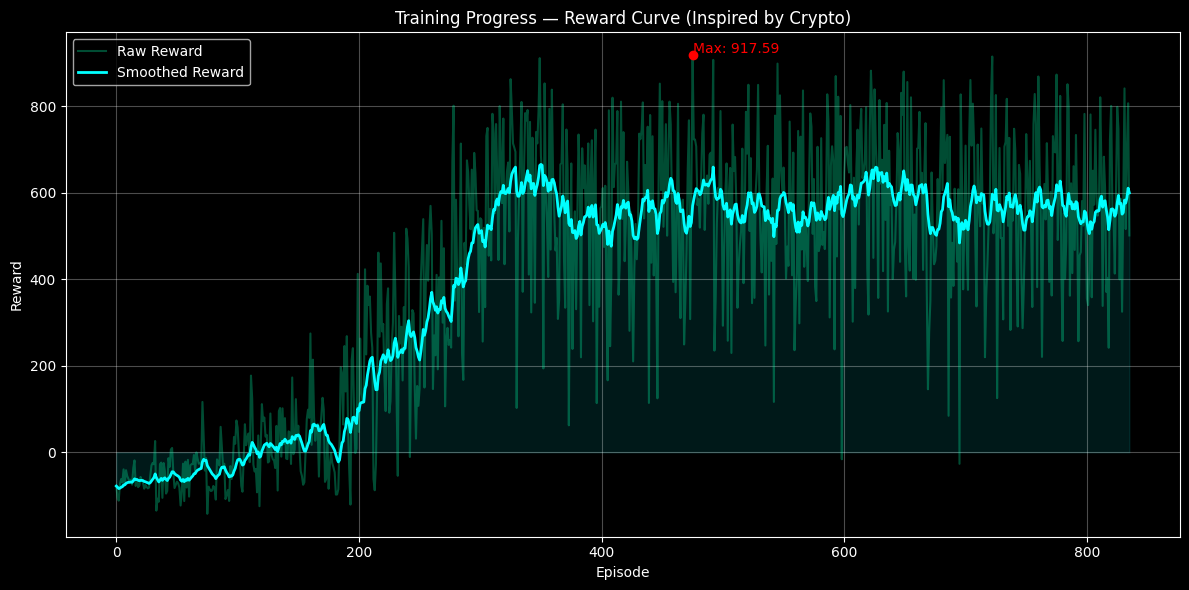



In [23]:
# ==== Epsilon Greedy Policy ====

# exploration rate
epsilon = 1.0
# minimum exploration rate
epsilon_min = 0.01
# dacay rate for epsilon after each episode
epsilon_decay =10000

epsilon_start = 1.0
epsilon_end = 0.05

total_steps = 0


# ==== Action ====
# act(): chooses an action based on the epsilon-greedy policy.
def act(state, rewards_per_episode):
    global total_steps

    short_term_reward_average = np.mean(rewards_per_episode[-10:])

    if len(rewards_per_episode) < 10:
      short_term_reward_average = -np.inf

    # ==== Modify Epsilon ====
    if short_term_reward_average < 300:
      eps_threshold = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * total_steps / epsilon_decay)
      total_steps += 1
    elif short_term_reward_average >= 300:
      eps_threshold = 0.1
      total_steps += 1

    if np.random.rand() <= eps_threshold:
        return random.randrange(action_size)
    # Add batch dimension
    # state: (96, 96, 3)
    # state[np.newaxis, ...]: (1, 96, 96, 3)
    # CNN model input: (batch_size, 96, 96, 3)
    q_values = model.predict(state[np.newaxis, ...], verbose=0)
    return np.argmax(q_values[0])

# Q-learning Update (Replay)

我們用之前的經驗來訓練DQN。
基本上經驗會放在一個baffur裡面。我們叫他 replay buffer。

⬇️ Replay 是學問所在。

## Double DQN Replay

In [26]:
#@tf.function
def train_step(states, target_qs, weights):

    with tf.GradientTape() as tape:
        q_pred = model(states, training=True)
        elementwise_loss = tf.keras.losses.Huber(reduction='none')(target_qs, q_pred)
        loss = tf.reduce_mean(elementwise_loss * weights)  # ← 重點：IS 加權
    grads = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(grads, model.trainable_variables))


def double_replay(batch_size, episode):
  global epsilon, steps

  # === Sample minibatch ===
  states, actions, rewards, next_states, dones, indices, weights = memory.sample(batch_size)

  # ==== Check ====
  if states.shape != (batch_size, 96, 96, 12):
    print(f"❌ Shape mismatch: got {states.shape}, skipping training")
    return

  # ==== Double DQN target ====
  next_q_main = model.predict(next_states, verbose=0)
  # Predict next Q-values using main model (for action selection)
  next_actions = np.argmax(next_q_main, axis=1)
  # Predict next Q-values using target model (for evaluation)
  next_q_target = target_model.predict(next_states, verbose=0)

  # ==== Get current Q values ====
  q_values = model.predict(states, verbose=0)

  # ==== TD error ====
  td_errors = []

  for i in range(batch_size):
      target = rewards[i] if dones[i] else rewards[i] + gamma * next_q_target[i][next_actions[i]]
      td_error = (target - q_values[i][actions[i]]) ** 2 + 1e-6 # ← TD error
      td_errors.append(td_error)
      q_values[i][actions[i]] = target

  # Train on updated Q-values
  # Call the tf.function-wrapped training step
  # ==== Training Step ====
  train_step(
    tf.convert_to_tensor(states, dtype=tf.float32),
    tf.convert_to_tensor(q_values, dtype=tf.float32),
    tf.convert_to_tensor(weights[:, None], dtype=tf.float32),  # 👈 shape=(batch_size, 1)
  )

  # ==== Update Priorities ====
  memory.update_priorities(indices, td_errors)

In [27]:
# ==== Test Cell ====

import numpy as np
import tensorflow as tf
from collections import deque
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense

# 1. 模擬一個簡單的 model 和 target_model
def build_dummy_model():
    inputs = Input(shape=(96, 96, 12))
    x = Conv2D(16, (3, 3), strides=2, activation='relu')(inputs)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(5)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

dummy_model = build_dummy_model()
dummy_target_model = tf.keras.models.clone_model(model)
dummy_target_model.set_weights(model.get_weights())

# 2. 假的 memory（你要保證你已經定義了 PrioritizedMultiStepReplayBuffer 與 SumTree）
memory = PrioritizedMultiStepReplayBuffer(capacity=1000, n_step=3, gamma=0.99)

# 3. 假資料塞進 buffer
for i in range(50):
    state = np.full((96, 96, 12), fill_value=i, dtype=np.uint8)
    next_state = np.full((96, 96, 12), fill_value=i+1, dtype=np.uint8)
    action = np.random.randint(0, 5)
    reward = np.random.rand()
    done = np.random.choice([False, True], p=[0.8, 0.2])
    memory.store(state, action, reward, next_state, done)

# 4. 定義 double_replay 所需的 global 變數
epsilon = 1.0
steps = 0
gamma = 0.99  # discount factor

# 5. 呼叫 double_replay 看能不能成功運作
try:
    double_replay(batch_size=16, episode=0)
    print("✅ `double_replay()` ran successfully!")
except Exception as e:
    print("❌ Error during `double_replay()`:")
    print(e)

Added to tree_idx=999, priority=1.0, data=(array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 

測試一下是不是能運作

# Training Loop 主要訓練迴圈

### Frame Stack 堆疊 Frame

In [28]:
# ==== Frame Stack ====
# Initialize buffer
NUM_FRAMES = 4
frame_buffer = deque(maxlen=NUM_FRAMES)

def preprocess_frame(frame, size=(96, 96), grayscale=False):
    if grayscale:
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, size)
        frame = np.expand_dims(frame, axis=-1)  # (96,96,1)
    else:
        frame = cv2.resize(frame, size)  # RGB
    return frame.astype(np.uint8)

### Shaping reward (Modify reward) Reward 微調
你可以指定某些針對 reward 的微調。當 Agent 採取某些 action 的時候，例如 action = 0 （原地不動），那麼就 punish 它。

In [32]:
def reward_shaping(action, reward, next_state=None, info=None):
  shaped_reward = float(reward)

  # Punish stay
  if action == 0:
    shaped_reward -= 0.1  # 懲罰原地不動
  elif action == 3:  # 加速
      shaped_reward += 0.05
  elif action in [1, 2]:  # 轉彎
      shaped_reward += 0.02
  elif action == 4:  # 減速
      shaped_reward -= 0.05

  return shaped_reward

# ==== How to Use ====
# In training loop:
# for each episode:
# reward = shaped_reward(action)

In [33]:
# ==== Display ====
from IPython.display import clear_output
import matplotlib.pyplot as plt
def plot_training_progress(rewards, smoothing=0.9):
    def smooth(data, weight):
        smoothed = []
        last = data[0]
        for point in data:
            smoothed_val = last * weight + (1 - weight) * point
            smoothed.append(smoothed_val)
            last = smoothed_val
        return smoothed

    smoothed_rewards = smooth(rewards, smoothing)

    clear_output(wait=True)
    plt.figure(figsize=(12, 6))
    plt.style.use("dark_background")  # 黑色背景

    x = np.arange(len(rewards))
    plt.plot(x, rewards, color="#00FFAA", alpha=0.3, label='Raw Reward')  # 淡綠色原始線
    plt.plot(x, smoothed_rewards, color="#00FFFF", linewidth=2.0, label='Smoothed Reward')  # 螢光藍平滑線

    # 填滿區域像 K 線背景振幅
    plt.fill_between(x, smoothed_rewards, color="#00FFFF", alpha=0.1)

    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Progress — Reward Curve (Inspired by Crypto)')
    plt.legend()
    plt.grid(alpha=0.3)

    # 標註最高點
    max_idx = np.argmax(rewards)
    plt.scatter([max_idx], [rewards[max_idx]], color='red', label='📈 ATH', zorder=5)
    plt.text(max_idx, rewards[max_idx]+5, f"Max: {rewards[max_idx]:.2f}", color='red')

    plt.tight_layout()
    plt.show()

## 主要訓練迴圈（Training Loop）

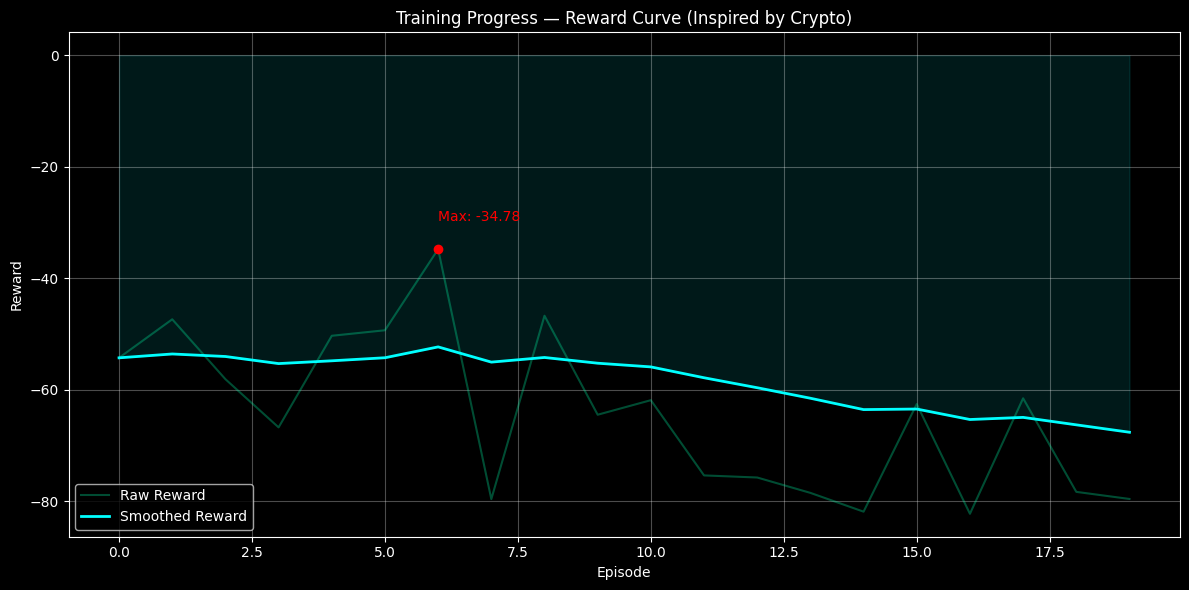

🎬 Episode 20 | 05:33:53 | Reward: -79.58
Top actions in this episode: [(np.int64(1), 80), (np.int64(4), 50), (0, 38), (2, 37), (3, 33)]


KeyboardInterrupt: 

In [36]:
# ==== Test Frame Stack by Me ====
from datetime import datetime
# ==== Build Target Network ====
target_model = build_model(input_shape=(96, 96, 12), action_size=5)
target_model.set_weights(model.get_weights())

# ==== Training Parameters ====
episodes = 1000 # More is good
batch_size = 128 # Minibatch size
gamma = 0.95 # Discount rate (~1 future is import)
max_step = 1000 # Max step per eposide
best_score = -np.inf

# ==== Before loop ====
steps = 0  # Initialize the steps

# ==== Define memory ====
memory = PrioritizedMultiStepReplayBuffer(capacity=100000, n_step=5, gamma=0.99)

# ==== Record ====
rewards_per_episode = []

# ==== Clear memory to ensure consistent state shapes ====
# This prevents the ValueError if memory contains states from a non-stacked training run.
memory.clear()

# ==== Training Loop ====
for episode in range(episodes):
  env = gym.make("CarRacing-v3",
               render_mode= None,
               lap_complete_percent=0.95,
               domain_randomize=False,
               continuous=False)
  action_history = []

  state, _ = env.reset()

  # ==== 插入 No-op 動作 ====
  for _ in range(50):
      state, _, terminated, truncated, _ = env.step(0)
      if terminated or truncated:
          break

  # Initialize stacking: RGB version
  # Preprocess after no-op
  # ==== Preprocess  ====
  state = preprocess_frame(state, grayscale=False)
  frame_buffer = deque([state] * 4, maxlen=4)
  # ==== Stack State ====
  stacked_state = np.concatenate(list(frame_buffer), axis=-1)
  episode_reward =0.0


  # ==== Logic ====
  # state → select action → step in env → get next_state, reward → modify → store in memory

  for time in range(max_step):
    steps += 1  # Ensure epsilon dacay
    # Choose action using epsilon-greedy policy
    # act() → strategy
    # Use stacked state

    # ==== Force Forward ====
    if episode < 5 and time < 100:
      action = np.random.choice([1, 2, 3])
    else:
      action = act(stacked_state, rewards_per_episode)

    action_history.append(action)

    # Take action
    total_reward = 0
    # ==== Frame Skipping ====
    for _ in range(4):  # frame skip 次數
        next_state, reward, terminated, truncated, _ = env.step(action)
        total_reward = total_reward + reward
        if terminated or truncated:
            break

    done = terminated or truncated

    if isinstance(next_state, tuple):
      next_state = next_state[0]

    next_state = preprocess_frame(next_state, grayscale=False)
    frame_buffer.append(next_state)
    stacked_next_state = np.concatenate(list(frame_buffer), axis=-1)

    # ==== Reward Shaping ====
    reward = reward_shaping(action, total_reward, next_state, None)

    if isinstance(next_state, tuple):
      next_state = next_state[0]

    # ==== Remember ====
    # Store experience in memory
    # remember → memorize (replay buffer)
    #remember(stacked_state, action, reward, stacked_next_state, done)
    memory.store(stacked_state, action, reward, stacked_next_state, done)

    # Update state
    stacked_state = stacked_next_state

    # Record reward
    episode_reward = episode_reward + float(reward)

    # If episode ends
    if done:
      eps_threshold_for_log = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * total_steps / epsilon_decay)
      rewards_per_episode.append(episode_reward)
      plot_training_progress(rewards_per_episode)
      print(f"🎬 Episode {episode+1} | {datetime.now().strftime('%H:%M:%S')} | Reward: {episode_reward:.2f}")
      break

  #Train the model using replay memory
  replay_start = 5000  # 可調
  if len(memory) > replay_start and len(memory) > batch_size:
    double_replay(batch_size, episode=episode)

  # Reset Target Network
  if episode % 10 == 0:
    target_model.set_weights(model.get_weights())

  # Update Best Score
  if episode_reward > best_score:
    best_score = episode_reward
    model.save('best_model.keras')
    print(f"✅ New Best Score {best_score}")

  print("Top actions in this episode:", Counter(action_history).most_common())
  print("======================================")
  env.close()

print(f"Training complete after {episodes} episodes.")
print(f"Best model score: {best_score:.2f}")



In [ ]:
# ==== Visualize rewards_per_episode ===

import numpy as np
import matplotlib.pyplot as plt

def plot_rewards(rewards, threshold=500, smooth_weight=0.9, highlight_max=True, std_band=True):
    def smooth(data, weight):
        smoothed = []
        last = data[0]
        for point in data:
            smoothed_val = last * weight + (1 - weight) * point
            smoothed.append(smoothed_val)
            last = smoothed_val
        return np.array(smoothed)

    rewards = np.array(rewards)
    x = np.arange(len(rewards))
    smoothed = smooth(rewards, smooth_weight)
    std = np.std(rewards[-20:])  # 選最後 20 次 episode 的標準差

    plt.figure(figsize=(12, 6))

    # Plot 原始 Reward（淡灰）
    plt.plot(x, rewards, alpha=0.3, label='Raw Reward', color='gray')

    # Plot 平滑 Reward（藍色）
    plt.plot(x, smoothed, label='Smoothed Reward', color='blue', linewidth=2)

    # STD ±1 標準差區間（淡藍色區塊）
    if std_band:
        plt.fill_between(x, smoothed - std, smoothed + std, alpha=0.15, color='skyblue', label='±1 Std')

    # 500 baseline
    plt.axhline(y=threshold, color='red', linestyle='--', label=f'Pass Threshold ({threshold})')

    # Highlight max reward
    if highlight_max:
        max_idx = np.argmax(rewards)
        max_reward = rewards[max_idx]
        plt.scatter(max_idx, max_reward, color='darkorange', label='Max Reward')
        plt.text(max_idx, max_reward + 15, f'{max_reward:.1f}', ha='center', fontsize=9, color='darkorange')

    # Title and label
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Progress with Smoothed Curve and Std Band')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Evaluation

In [ ]:
# Re-initialize the environment for evaluation
# Use the same parameters as the training environment

# ==== GIF file ====
output_dir = "/content/gifs"  # 你可以改成你要存的資料夾
os.makedirs(output_dir, exist_ok=True)  # 若不存在就創建資料夾

# ==== Evaluation ====
evaluation_episodes = 50 # Number of evaluation
score = []

# ==== Initialize Environment ====
env = gym.make("CarRacing-v3",
              render_mode= 'rgb_array',
              lap_complete_percent=0.95,
              domain_randomize=True,
              continuous=False)



for episode in range(evaluation_episodes):
  # ==== Make GIF ====
  gif_frames = []

  obs, _ = env.reset()
  frame = preprocess_frame(obs)

  # 初始化 frame buffer
  frame_buffer = deque([frame]*NUM_FRAMES, maxlen=NUM_FRAMES)
  stacked_state = np.concatenate(list(frame_buffer), axis=-1)  # shape: (96, 96, 12) if RGB

  total_reward = 0


  for time in range(max_step):
    gif_frames.append(env.render())

    # Step 1: 選 action（用 stacked_state）
    action = np.argmax(model.predict(stacked_state[np.newaxis, ...], verbose=0)[0])

    # Step 2: 與環境互動
    next_obs, reward, terminated, truncated, _ = env.step(action)

    # Step 3: 預處理 frame
    next_frame = preprocess_frame(next_obs)

    # Step 4: 更新 frame buffer + stacked_state
    frame_buffer.append(next_frame)
    stacked_state = np.concatenate(list(frame_buffer), axis=-1)

    # Step 5: 更新 reward 累加
    total_reward += float(reward)

    # Step 6: 檢查 done
    done = terminated or truncated
    if done:
        break

  score.append(total_reward)  # 加在這裡
  print(f"Episode: {episode+1}/{evaluation_episodes}, Score: {total_reward:.2f}")
  gif_path = os.path.join(output_dir, f"episode_{episode+1:03d}.gif")
  imageio.mimsave(gif_path, gif_frames, fps=30)

env.close()

# ==== Scores ====
average_score = np.mean(score)
max_score = np.max(score)
min_score = np.min(score)
std_score = np.std(score)

print(f'Evaluation complete after {evaluation_episodes}')
print(f"Average Score: {average_score:.2f}")
print(f"Max Score: {max_score:.2f}")
print(f"Min Score: {min_score:.2f}")
print(f"Std Score: {std_score:.2f}")

# ==== Visualization ====
def smooth(data, weight=0.9):
    smoothed = []
    last = data[0]
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return np.array(smoothed)

smoothed = smooth(score)
std = np.std(score)

# ==== Plot ====
plt.figure(figsize=(12, 6))

# ==== Use White Background ====
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

x = np.arange(len(score))

plt.plot(x, score, label='Raw Reward', alpha=0.3)

plt.plot(x, smoothed, label='Smoothed Reward', linewidth=2)

# ==== Std Band ====

plt.fill_between(x, smoothed - std, smoothed + std, alpha=0.2, color='skyblue', label='±1 Std')

# ==== Baseline ====
plt.axhline(y=500, color='red', linestyle='--', label='Pass Threshold')

# ==== Title and label ====
plt.title('Evaluation Reward Trend with Std Band')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.grid()
plt.show()

